# Using **Variational Quantum Adiabatic Algorithm** With Neutral Atom Quantum Computer

## Introduction

In this notebook, we explore a hybrid classical-quantum algorithm for solving an antenna placement optimization problem. The objective is to maximize the coverage of a region while minimizing interference between antennas. This problem involves a vast search space of possible antenna positions, which poses a significant computational challenge. To address this, we first use a **k-means clustering method** to generate a grid of k points. This allows to partition the population into k clusters, and then to place each grid point at each cluster centroid. Then we use a **Neutral Atom Quantum Computing (NAQC)** to embed this graph in a register, and optimize the pulse parameters to get the **Maximum Weighted Independent Set** (MWIS) corresponding to the best coverage. In order to have different detuning for each qubits, we also implement a detuning map channel that is optimized alongside the pulse parameters.

### K-Means Clustering Method
K-means clustering is a technique that groups data points into k  clusters by minimizing the distance between points and their nearest cluster center, or centroid.

### Hybrid Classical-Quantum Workflow

The algorithm proceeds as follows:

1. **Grid Initialization**: We generate k grid points using the K-Means Clustering Method `KMeans` from `scikit-learn`.
2. **Channel Declarations**: We define the *detuning map* channel with an initial weight for each qubit proportional to its population coverage, and retrive the pulse parameters that were optimized in `pulse_optimization.ipynb`.
3. **Optimization**: This hybrid approach use 

1. **Grid Initialization**: We start with a random grid layout.
2. **Simulated Annealing Iteration**: At each iteration, we generate a new candidate layout by following the rules of simulated annealing.
3. **Quantum MIS Calculation**: Using the NAQC, we compute the MIS on the current grid layout, thereby focusing only on atoms that form an independent set and reducing unnecessary configurations.
4. **Optimization**: This hybrid approach use an **optimisation function** based on Gaussian processes `gp_minimize` from `scikit-optimize` to change the pulse parameters and detuning map weights in order to get the MWIS corresponding to the maximum coverage.


In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.spatial import KDTree, distance_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
import json
from skopt import gp_minimize
# graph representation
import networkx as nx
# Pulser imports
import pulser as pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import SimConfig, QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform

### Extract the city data

In [2]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[0]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])

In [3]:
# function to compute coverage of an array of grid_points
def simple_coverage(population_x, population_y, grid_points, R_antennas):
    z_coverage = np.zeros(len(grid_points))
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        z_coverage[i] = cov
    return z_coverage
    

### Generate a grid

We generate a triangular grid and adaptively select `max_grid_points` from the triangular grid. We take `max_grid_points` equal to 10 to minimize the time taken for Qutip emulator to run the quantum program. 

In [4]:
def generate_grid(population_x, population_y, k, min_distance):
    """
    Finds k grid points from the population positions using k-means clustering.
    Initially, places points separated by at least the specified minimum distance.
    If fewer than k points can be placed under this constraint, remaining points are 
    placed in areas with the lowest density of current points for even coverage.

    Parameters:
    - population_x (array-like): Array of x-coordinates of the population.
    - population_y (array-like): Array of y-coordinates of the population.
    - k (int): Number of grid points to return.
    - min_distance (float): Minimum required distance between grid points.

    Returns:
    - grid_points (ndarray): Array of shape (k, 2) with the selected grid points (x, y).
    - kmeans (KMeans): Fitted KMeans model, used for clustering labels if needed.
    """
    
    # Combine population coordinates
    population_coords = np.column_stack((population_x, population_y))

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(population_coords)
    initial_grid_points = kmeans.cluster_centers_

    # Function to filter grid points based on minimum distance
    def filter_points(points, min_dist):
        filtered_points = []
        for point in points:
            if all(np.linalg.norm(point - np.array(p)) >= min_dist for p in filtered_points):
                filtered_points.append(point)
        return np.array(filtered_points)

    # Filter initial grid points based on minimum distance
    filtered_grid_points = filter_points(initial_grid_points, min_distance)

    # Add points in areas with lowest density if we need more points
    while len(filtered_grid_points) < k:
        # Calculate density by finding the sum of distances to all other points
        remaining_points = population_coords[np.random.choice(len(population_coords), 500, replace=False)] # Sample for speed
        distances = distance_matrix(remaining_points, filtered_grid_points)
        density_scores = distances.min(axis=1)

        # Select the point with the lowest density score as the new grid point
        lowest_density_point = remaining_points[np.argmax(density_scores)]

        # Add the new point if it meets the distance criteria or if we can't add more points otherwise
        if all(np.linalg.norm(lowest_density_point - np.array(p)) >= min_distance for p in filtered_grid_points):
            filtered_grid_points = np.vstack([filtered_grid_points, lowest_density_point])
        else:
            # Add it without the distance constraint if we're still below k points
            filtered_grid_points = np.vstack([filtered_grid_points, lowest_density_point])

    # Ensure the result contains exactly k points
    return filtered_grid_points[:k], kmeans


In [5]:
# Define parameters
population_x = x
population_y = y
# Radius of coverage for each antenna
R_antennas = 25
# Maximum number of antennas
max_grid_points = 10
# Find grid points and get the k-means model for clustering
grid_points, kmeans = generate_grid(population_x, population_y, max_grid_points, R_antennas)
# Calculate final coverage for the selected grid layout
z_coverage = simple_coverage(population_x, population_y, grid_points, R_antennas)

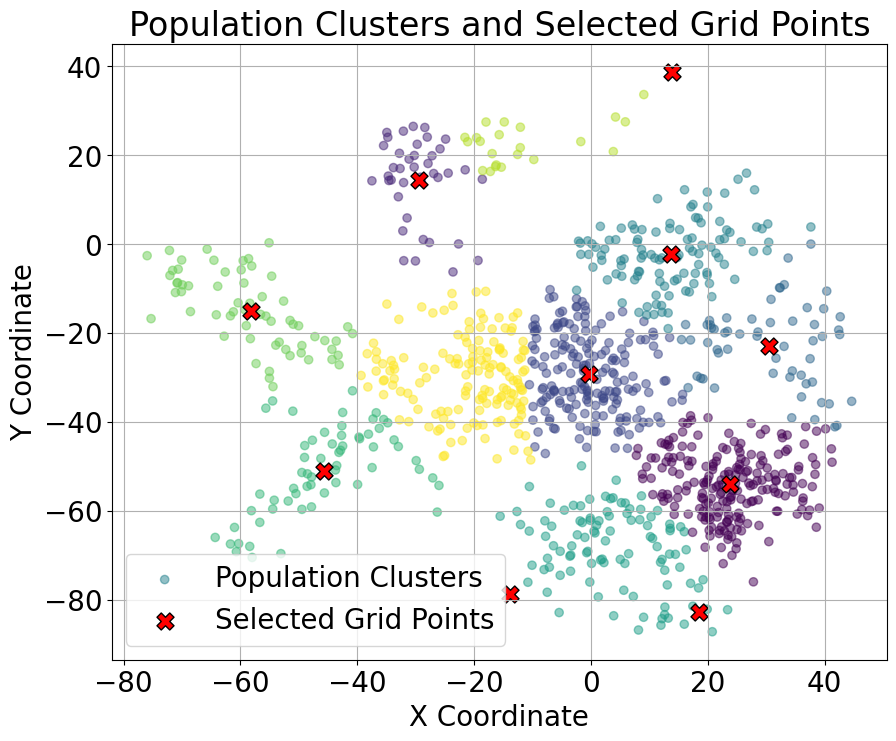

In [6]:
# Plot population points with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(population_x, population_y, c=kmeans.labels_, cmap='viridis', marker='o', alpha=0.5, label='Population Clusters')

# Plot grid points (cluster centroids)
plt.scatter(grid_points[:, 0], grid_points[:, 1], c='red', s=150, edgecolor='black', marker='X', label='Selected Grid Points')

# Labels and legend with adjusted font sizes
plt.xlabel('X Coordinate', fontsize=20)
plt.ylabel('Y Coordinate', fontsize=20)
plt.title('Population Clusters and Selected Grid Points', fontsize=24)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

### Device selection

We choose the `MockDevice` and embedd the `grid_points` to the register coordinate with appropriate scaling.

In [7]:
device_used = MockDevice
# create an UD graph embedding using appropriate coordinates
coords = np.array(grid_points)
val = np.min(pdist(coords))
factor = 6/val
coords = coords*factor # Normalize to 6 b.c. minimum distance on real NAQC is around 6um

# Load optimized pulse parameters from file
optimized_data = np.load('media/optimized_values.npz')
T = optimized_data['T'] # Total pulse duration
omega_max = float(optimized_data['omega_max']) # Maximum Rabi frequency
delta_0 = float(optimized_data['delta_0']) # Initial detuning
delta_f = float(optimized_data['delta_f']) # Final detuning
# Random instance of the parameter space
params = optimized_data['param']
m = (int)(len(params)/2) # Number of parameters for the ramp
amp_params = params[:m] # Amplitude parameters
det_params = params[m:] # Detuning parameters

# scaling of the graph to map it inside the register
rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
R_antennas = 25*factor
factor_for_rydberg_scaling = (rydberg_radius + 1e-3)/(2*R_antennas)
R_antennas = R_antennas * factor_for_rydberg_scaling
coords = coords * factor_for_rydberg_scaling

# Number of qubits
N = len(coords)
# Number of samples to probe
N_samples = 1000

# Noise configuration
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}
print('Omega_max:', omega_max)
print('Rydberg radius:', rydberg_radius)
print('Delta_0:', delta_0)
print('Delta_f:', delta_f)
print('Minimum distance:', np.min(pdist(coords)))

Omega_max: 6.283185307179586
Rydberg radius: 9.756753962298905
Delta_0: -37.69911184307752
Delta_f: 12.566370614359172
Minimum distance: 5.20082417570337


### Extract Q for the QUBO cost function

In [8]:
# interaction coefficients U_ij
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
# fill the diagonal with negative of the coverage of each grid point
np.fill_diagonal(Q, -z_coverage)

In [9]:
trap_coordinates = np.array(grid_points)
weights_param = 1 - np.array(z_coverage/np.max(z_coverage))
n_weights = len(weights_param)

# Print the weights for each antenna
for i, weight in enumerate(weights_param):
    print(f"Antenna {i+1}: Coverage = {z_coverage[i]}, Weight = {weight:.2f}")

Antenna 1: Coverage = 283.0, Weight = 0.20
Antenna 2: Coverage = 57.0, Weight = 0.84
Antenna 3: Coverage = 354.0, Weight = 0.00
Antenna 4: Coverage = 145.0, Weight = 0.59
Antenna 5: Coverage = 176.0, Weight = 0.50
Antenna 6: Coverage = 91.0, Weight = 0.74
Antenna 7: Coverage = 72.0, Weight = 0.80
Antenna 8: Coverage = 6.0, Weight = 0.98
Antenna 9: Coverage = 58.0, Weight = 0.84
Antenna 10: Coverage = 104.0, Weight = 0.71


### Create the register

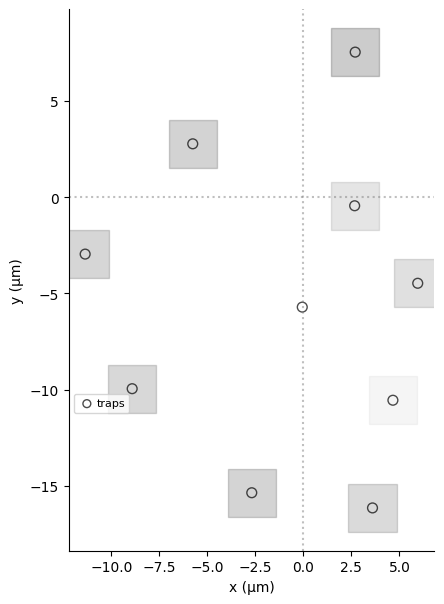

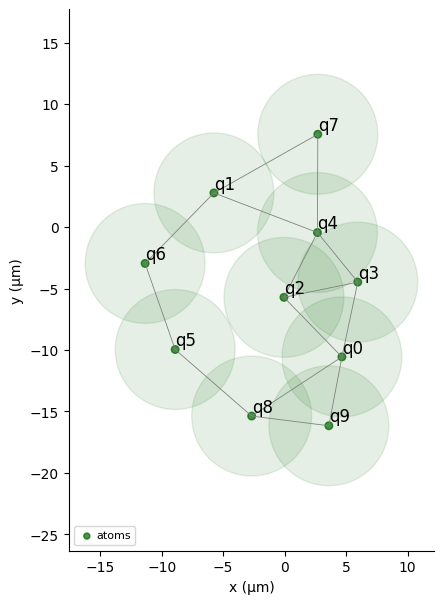

In [10]:
reg = Register.from_coordinates(
    coords, center=False, prefix="q"
)
det_map_from_reg = reg.define_detuning_map(
    {
        f"q{i}": weights_param[i] for i in range(len(weights_param))
    }  # mapping between qubit ids and weights
)

det_map_from_reg.draw()
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(omega_max),
    draw_graph=True,
    draw_half_radius=True,
)

{2: Text(-0.05792776086180717, -5.711869060755005, '2'),
 4: Text(2.6683341856569514, -0.43724689992388377, '4'),
 3: Text(5.951152623850818, -4.471063356883103, '3'),
 5: Text(-8.909670321982134, -9.95778008784021, '5'),
 8: Text(-2.6864968068526194, -15.372361604363094, '8'),
 0: Text(4.659440063563576, -10.558330497209262, '0'),
 9: Text(3.5976616597041953, -16.162401702879396, '9'),
 1: Text(-5.757657279376444, 2.7860229036019555, '1'),
 7: Text(2.696996688748583, 7.558361737170246, '7'),
 6: Text(-11.356651288720547, -2.952980951051674, '6')}

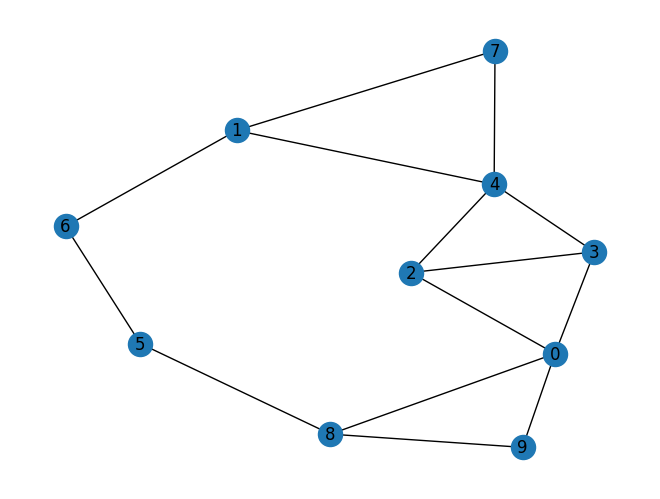

In [11]:
graph = nx.Graph()
edges = KDTree(coords).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

In [12]:
def create_interp_pulse(amp_params, det_params):
    return Pulse(
        InterpolatedWaveform(T, [1e-9, *amp_params, 1e-9]),
        InterpolatedWaveform(T, [delta_0, *det_params, delta_f]),
        0,
    )

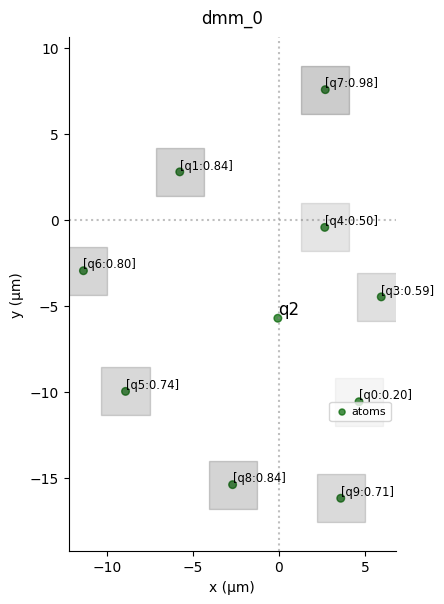

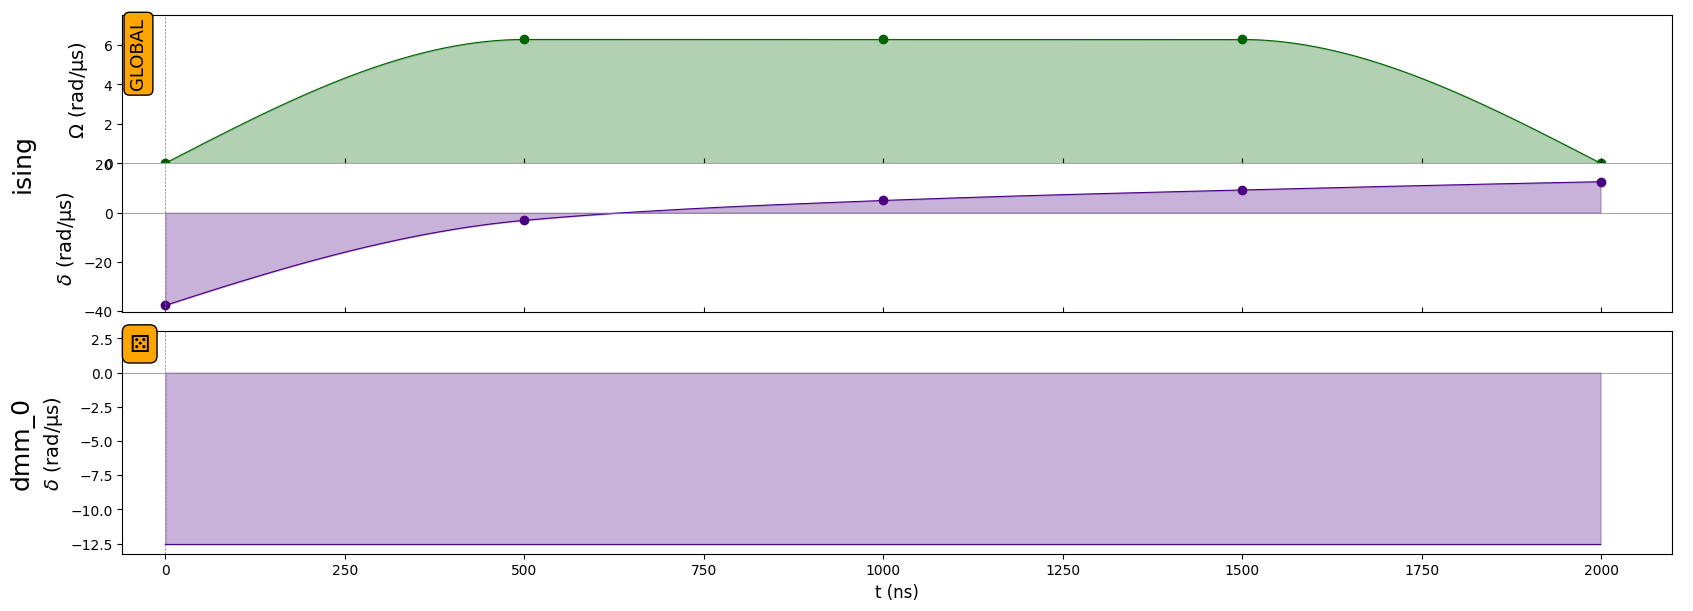

In [19]:
seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")
seq.add(create_interp_pulse(amp_params, det_params), "ising")

total_duration = T
waveform = ConstantWaveform(total_duration, -delta_f)

seq.config_detuning_map(det_map_from_reg, "dmm_0")
# Concatenate the waveforms
seq.add_dmm_detuning(waveform, "dmm_0")
seq.draw(draw_detuning_maps=True)

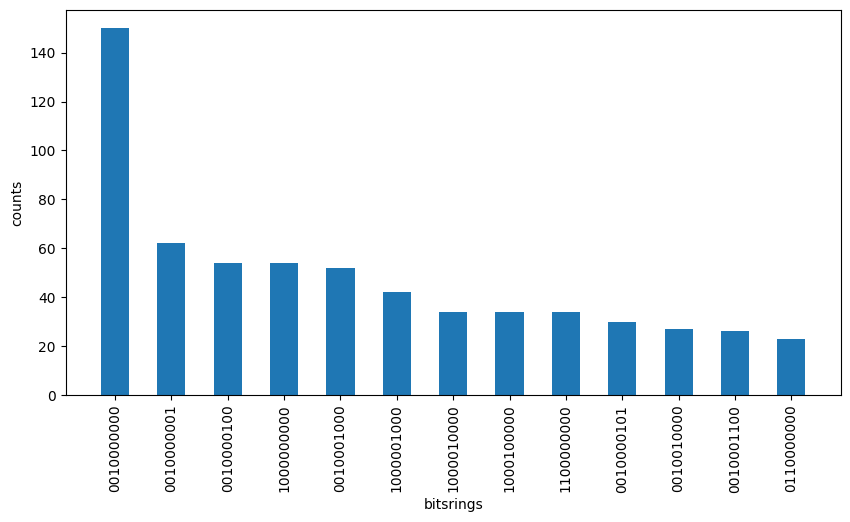

In [20]:
simulator = QutipEmulator.from_sequence(seq)
results = simulator.run()
results = simulator.run(progress_bar=False)
count_dict = results.sample_final_state(N_samples=N_samples)
most_frequent = {k:v for k,v in count_dict.items() if v>20}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

# Optimization

In [21]:
# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

In [22]:
# Function to return the size of the Maximum Independent Set (MIS)
def mis_coverage(graph, bitstring):
    """
    Calculates the coverage of the independent set represented by the bitstring for a given graph.
    
    Parameters:
    - graph: The graph in which the independent set is being checked.
    - bitstring: A binary string representing nodes in the independent set (1 if node is in the set, 0 otherwise).
    
    Returns:
    - Coverage of the independent set if it is valid, otherwise a penalty (-4) if the set is not independent.
    """

    # Convert the bitstring into a list of node indices representing the independent set
    node_set = convert_to_indices(bitstring)

    coverage = 0
    
    # Check if the node set is an independent set
    for node in node_set:
        for neighbor in graph.neighbors(node):
            if neighbor in node_set:  # If any neighbor of a node in the set is also in the set, it is not an independent set
                return 0  # Return 0 if not an independent set
        coverage += z_coverage[node]
    
    # Return the coverage of the independent set if it passes the check
    return coverage

# Function to calculate the weighted mean coverage of the MIS from a set of solutions
def mean_mean_coverage(graph, solution_dict):
    """
    Calculates the weighted mean coverage of Maximum Independent Sets (MIS) based on solutions provided in solution_dict.
    
    Parameters:
    - graph: The graph in which the MIS is being calculated.
    - solution_dict: Dictionary with bitstrings as keys and counts as values. Each bitstring represents a possible
      independent set, and the count represents how often this set was observed.
    
    Returns:
    - mean_coverage: The weighted mean coverage of the MIS across all solutions, accounting for penalties and frequencies.
    """

    total_weighted_coverage = 0  # Sum of weighted coverage for each solution
    total_counts = 0  # Total count of solutions
    list_coverages = []  # List to store the coverage of each solution's MIS

    # Iterate over each bitstring and its count in the solution dictionary
    for bitstring, count in solution_dict.items():
        coverage = mis_coverage(graph, bitstring)
        total_weighted_coverage += coverage * count
        total_counts += count

    mean_coverage = total_weighted_coverage / total_counts

    return mean_coverage  # Return the mean coverage of the MIS

In [ ]:
def quantum_loop(params):
    # create register
    reg = Register.from_coordinates(
        coords, center=False, prefix="q"
    )
    # add detuning map
    det_map_from_reg = reg.define_detuning_map(
        {
            f"q{i}": params[2*m+i] for i in range(n_weights)
        }  # mapping between qubit ids and weights
    )
    # Create a sequence
    seq = Sequence(reg, device_used)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(create_interp_pulse(params[:m], params[m:m:2*m+1]), "ising")
    # detuning waveform
    total_duration = T
    waveform = ConstantWaveform(total_duration, -delta_f/5)
    # add detuning map
    seq.config_detuning_map(det_map_from_reg, "dmm_0")
    seq.add_dmm_detuning(waveform, "dmm_0")
    # Run the simulation
    simulator = QutipEmulator.from_sequence(seq, sampling_rate=0.5)
    results = simulator.run(progress_bar=False)
    # Get the final state
    count_dict = results.sample_final_state(N_samples=N_samples)
    
    # create an ordered dictionnary of the results
    most_frequent = {k:v for k,v in count_dict.items() if v>10}
    results_dictionnary = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
    # Calculate the mean coverage of the MIS
    mean_coverage = mean_mean_coverage(graph, results_dictionnary)

    return -mean_coverage


In [24]:
# Define the bounds for the optimization
bounds = [(0.0, omega_max)] * m + [(delta_0, delta_f)] * m + [(0.0, 1.0)] * n_weights
# Number of random starts and calls
n_r = 30
n_c = 120
# Initial parameters
initial_param = np.concatenate((params, weights_param))
# Run the optimization
RESULT = gp_minimize(
    quantum_loop, # the function to minimize
    bounds, # the bounds on each dimension of x
    x0=initial_param.tolist(), # initial parameters
    n_random_starts=n_r, # the number of random initialization points
    n_calls=n_c, # the number of subsequent evaluations of f(x)
    verbose=False, # the number of subsequent evaluations of f(x)
)

Mean coverage: 272.9148311306902
Mean coverage: 227.92317708333334


KeyboardInterrupt: 

In [ ]:
def sort_improv(RESULT):
    score_vals = RESULT.func_vals
    min = score_vals[0]
    score_list = []
    for s in score_vals:
        if s < min:
            min = s
            score_list.append(min)
        else:
            score_list.append(min)
    return score_list

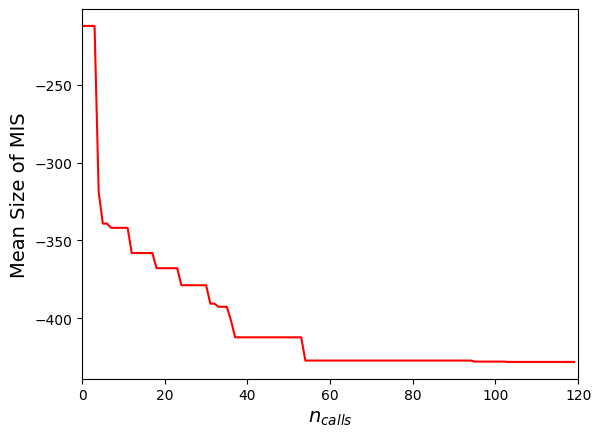

In [ ]:
fig = plt.figure()
plt.plot(range(n_c), np.abs(sort_improv(RESULT)), "r-")
plt.title("Optimization Progress", fontsize=20)
plt.xlabel(r"$n_{calls}$", fontsize=20)
plt.ylabel("Mean Coverage of MIS", fontsize=20)
plt.xlim(0, n_c)
plt.xticks(fontsize=20)
plt.show()

In [ ]:
# create register
reg = Register.from_coordinates(
    coords, center=False, prefix="q"
)
# add detuning map
det_map_from_reg = reg.define_detuning_map(
    {
        f"q{i}": RESULT.x[2*m+i] for i in range(n_weights)
    }  # mapping between qubit ids and weights
)
# Create a sequence
seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")
seq.add(create_interp_pulse(RESULT.x[:m], RESULT.x[m:m:2*m+1]), "ising")
# detuning waveform
total_duration = T
waveform = ConstantWaveform(total_duration, -delta_f/5)
# add detuning map
seq.config_detuning_map(det_map_from_reg, "dmm_0")
seq.add_dmm_detuning(waveform, "dmm_0")
# Run the simulation
simulator = QutipEmulator.from_sequence(seq, sampling_rate=0.5)
results = simulator.run(progress_bar=False)
# Get the final state
count_dict = results.sample_final_state(N_samples=N_samples)

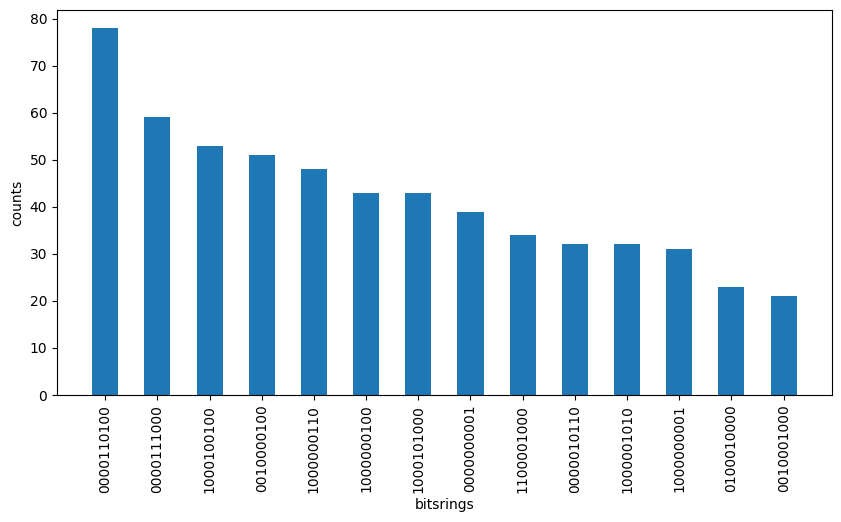

In [ ]:
simulator = QutipEmulator.from_sequence(seq)
results = simulator.run()
results = simulator.run(progress_bar=False)
count_dict = results.sample_final_state(N_samples=N_samples)
most_frequent = {k:v for k,v in count_dict.items() if v>20}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()


Most weighted independent set: 0000010110 with counts 32
Most counts independent set: 0000110100 with counts 78


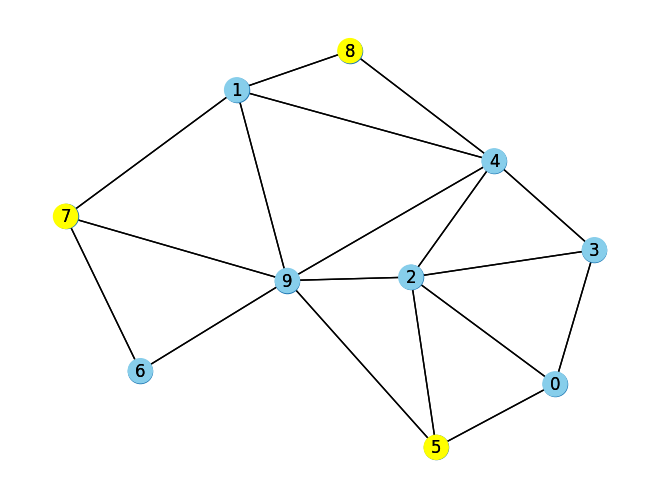

In [ ]:
# Sort the bitstrings in descending order by frequency
solution = [key for key, value in sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)]

# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Function to check if a set of nodes is an independent set
def is_independent_set(graph, node_indices):
    for node in node_indices:
        for neighbor in graph.neighbors(node):
            if neighbor in node_indices:
                return False
    return True

# Find the maximum weight for valid independent sets
list_weights = []
valid_solutions = []
for sol in solution:
    highlighted = convert_to_indices(sol)
    # Check if highlighted nodes form an independent set
    if is_independent_set(graph, highlighted):
        valid_solutions.append(sol)
        list_weights.append(np.sum(highlighted))


# If there are valid independent sets, find the one with the maximum weight
if valid_solutions:
    ind_max = np.argmax(list_weights)
    highlighted_nodes = convert_to_indices(valid_solutions[ind_max])
    print(f'Most weighted independent set: {valid_solutions[ind_max]} with counts {C[str(valid_solutions[ind_max])]}')
    print(f'Most counts independent set: {solution[0]} with counts {C[str(solution[0])]}')
else:
    highlighted_nodes = []  # No valid independent set found

# Draw the graph with colored nodes
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

# Assign colors: 'yellow' for highlighted nodes, 'skyblue' for others
node_colors = ['yellow' if node in highlighted_nodes else 'skyblue' for node in graph.nodes()]

nx.draw(graph, pos=coords, node_color=node_colors, with_labels=True)

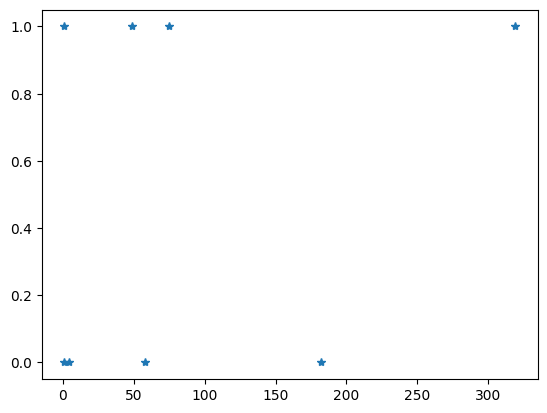

In [ ]:
plt.plot(z_coverage, RESULT.x[2*m:], "*")